<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/master/notebooks/covid-19-lockdowns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
!pip install --quiet git+https://github.com/oughtinc/ergo.git@006430b8701d461073a6c74ececf9fb12c7411c2
!pip install --quiet seaborn plotnine

In [0]:
import requests
import torch
import io
import zipfile
import os
import ergo
import requests
import scipy.stats
import plotnine

import seaborn as sns 
import pandas as pd
import numpy as np

from datetime import date, datetime, timedelta
from types import SimpleNamespace
from typing import List
from plotnine import ggplot, geom_point, aes, geom_vline, stat_smooth, facet_wrap, labs, guides
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Log into a Metaculus account

If running in a collab notebook, please enter your Metaculus credentials here 

In [0]:
def is_local():
  try:
    %env USER
    return True
  except:
    return False

metaculus_api = "pandemic"

if is_local():
  from dotenv import load_dotenv
  load_dotenv() 
  metaculus = ergo.Metaculus(username=os.getenv("METACULUS_USERNAME"), password=os.getenv("METACULUS_PASSWORD"), api_domain=metaculus_api)
else: 
  try:    
    metaculus = ergo.Metaculus(username="djthorne", password="5q9YW&aXN#leQhSNp3Sw", api_domain=metaculus_api)  
  except: 
    print(f'WARNING, You will need to enter your metaculus credentials in this cell')


# Questions

Here are the question we want to forecast:

In [0]:
question_ids = [
  3935,
  3948,
  3952,
  3941,
  3939,
  3937
]
question_names = [
    "The United Kingdom",
    "France",
    "The State of New York",
    "Poland",
    "The State of California",
    "Italy"
]


areas = question_names
questions = [metaculus.get_question(id, name=name) for (name, id) in zip(question_names, question_ids)]
#ergo.MetaculusQuestion.to_dataframe(questions)


# Assumptions and Question Information


*  intensity---a 1-5 corresponding to the severity/degree of adherence of the social distancing, with 5 being the most strictly observed/enforced social distancing 
*  re-evaluation---date at which government said they would re-assess lockdown


**TODO** consider factoring out assumptions and factual data





In [0]:
Area = dict
assumptions = SimpleNamespace()

assumptions.lockdowns = {
  "New York" : {
    "data_key" : "New York",
    "question_name" : "The State of New York",
    "start": date(2020, 3, 21),
    "intensity": 3,
    "end": None #pendulum.Date(2020, X, X)
  },
  "California" : {
    "data_key" : "California",
    "question_name" : "The State of California", 
    "start": date(2020, 3, 22),
    "end": None #date(2020, X, X)
  },
  "United Kingdom": {
    "data_key" : "United Kingdom",
    "question_name" : "The United Kingdom", 
    "start": date(2020, 3, 23),
    "re_evaluated": None, 
    "intensity": 3, 
    "end": None #date(2020, X, X)
  },
  "France": {
    "data_key" : "France",
    "question_name" : "France", 
    "start": date(2020, 3, 17),
    "re_evaluated": date(2020, 4, 1),
    "intensity": 3, 
    "end": None #date(2020, X, X)
  },
  "Poland": {
    "data_key": "Poland",
    "question_name" : "Poland",
    "start": date(2020, 3, 25),
    "re_evaluated": date(2020, 4, 11),
    "end": None #date(2020, X, X)
  },
  "Italy": {
    "data_key": "Italy",
    "question_name" : "Italy",
    "start": date(2020, 3, 23),
    "end": None #date(2020, X, X)
  }
}

Helper Functions

In [0]:
#hack implementation of date.fromisoformat (is in datetime @ pyton 3.7)
def fromisoformat( xdate): 
    return datetime.strptime(xdate, '%Y-%m-%d').date()


# This allows access to the right assumptions using a question name. 
def get_assumptions(key, assumptions = assumptions.lockdowns):
  if isinstance(key, str):
    if key in assumptions:
      return assumptions[key]
    else:
      print(f"No assumptions for data key: {key}")
  elif issubclass(type(key), ergo.metaculus.MetaculusQuestion):
    for k,v in assumptions.items():
      if v['question_name'] == key.name:
        return v
      print(f"No assumptions for question: {question.name}")
  else:
    print(f"Neither a question nor a data_key was passed")   


# ripped from https://techoverflow.net/2018/01/16/downloading-reading-a-zip-file-in-memory-using-python/
def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                yield zipinfo.filename, thefile



# Data

We now have predictions from http://www.healthdata.org/covid/data-downloads

***TODO*** if something like this is going to persist, then consider migrating to ergo/data/covid19.py

Get Data

In [0]:
url="https://ihmecovid19storage.blob.core.windows.net/latest/ihme-covid19.zip"

for name, xfile in download_extract_zip(url):
    if os.path.basename(name) =="Hospitalization_all_locs.csv":
        infections_df = pd.read_csv(xfile)


Clean and Enhance Data

**variable description**
* admis_mean = daily # of admissions to hospital
* allbed_mean = cumsum of admis_mean




In [0]:
#filter data        
infections_df = infections_df.loc[infections_df['location_name'].isin(["New York", "California", "United Kingdom", "France", "Poland",  "Italy"]),
                                  ['location_name', 'date', 'admis_mean', 'newICU_mean', 'deaths_mean', 'totdea_mean', 'allbed_mean', 'ICUbed_mean', 'bedover_mean', 'icuover_mean']]

#infections_df['location_name'].unique() 

# calculate days from lockdown
def calulate_days_from_lockdown_start(df: pd.core.frame.DataFrame):
    lockdown_start = get_assumptions(df['location_name'])['start']
    return (lockdown_start - fromisoformat(df['date'])).days

infections_df['days_from_lockdown'] = infections_df.apply(lambda x: calulate_days_from_lockdown_start(x), axis=1)

# calculate cumulative addmissions
infections_df['admis_cum'] = infections_df['admis_mean'].cumsum() 

# calculate doubling rate
infections_df['doubling_rate_in_days'] = infections_df['admis_cum'] / infections_df['admis_mean']

# calculate the new cases as a percentage of previous total
infections_df['progression'] =  infections_df['admis_cum'] / infections_df['admis_mean']
infections_df['progression'] = infections_df['progression'].apply(lambda x: min(x, 365)) # we don't care about doubling rates longer than a year (at least)

# remove all NAs
infections_df.fillna(0)

# drop first day without ability to lag
#infections_df.drop(infections_df.index[0], inplace=True) 

#pd.set_option('display.max_rows', None)




,location_name,date,admis_mean,newICU_mean,deaths_mean,totdea_mean,allbed_mean,ICUbed_mean,bedover_mean,icuover_mean,days_from_lockdown,admis_cum,doubling_rate_in_days,progression
2365,United Kingdom,2020-01-03,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,80,0.000000,0.0,0.0
2366,United Kingdom,2020-01-04,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,79,0.000000,0.0,0.0
2367,United Kingdom,2020-01-05,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,78,0.000000,0.0,0.0
2368,United Kingdom,2020-01-06,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,77,0.000000,0.0,0.0
2369,United Kingdom,2020-01-07,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,76,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26225,California,2020-07-31,0.0,0.0,0.0,1483.187,0.0,0.0,0.0,0.0,-131,337850.358464,inf,365.0
26226,California,2020-08-01,0.0,0.0,0.0,1483.187,0.0,0.0,0.0,0.0,-132,337850.358464,inf,365.0
26227,California,2020-08-02,0.0,0.0,0.0,1483.187,0.0,0.0,0.0,0.0,-133,337850.358464,inf,365.0
26228,California,2020-08-03,0.0,0.0,0.0,1483.187,0.0,0.0,0.0,0.0,-134,337850.358464,inf,365.0


# Explore Features

## Hospital Admissions

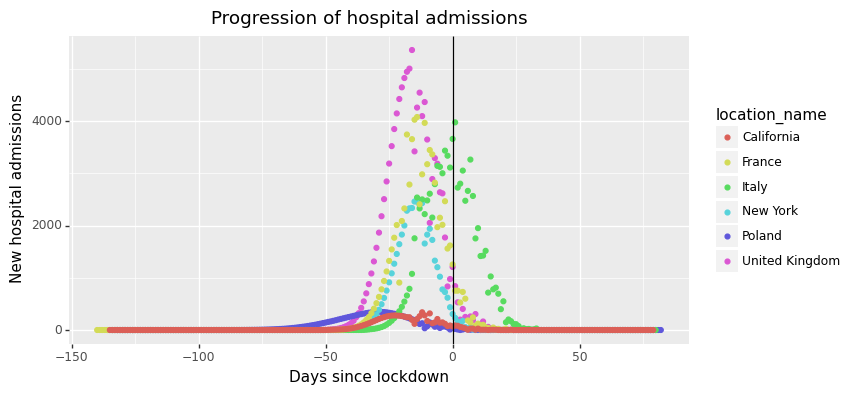

<ggplot: (-9223363301234809035)>

In [0]:

plotnine.options.figure_size = (8,4)
(ggplot(infections_df, aes('days_from_lockdown', 'admis_mean', color='location_name'))
     + geom_point()
     + geom_vline(xintercept=0) 
     + labs(x='Days since lockdown',  y='New hospital admissions', title='Progression of hospital admissions')
  )


Examine the evolution of the rate of the spread of the infection

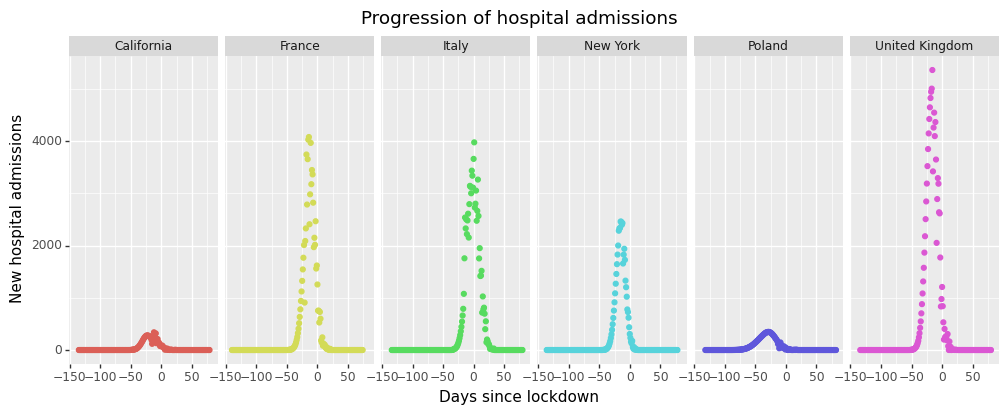

<ggplot: (8735616049286)>

In [0]:
  plotnine.options.figure_size = (12,4)
  (ggplot(infections_df, aes('days_from_lockdown', 'admis_mean', color='location_name'))
   + geom_point()
   + facet_wrap('~location_name', nrow=1)
   + labs(x='Days since lockdown',  y='New hospital admissions', title='Progression of hospital admissions')
   + guides(color=False)
   )

## Bedover 
 [covid all beds needed] - ([total bed capacity] - [average all bed usage])

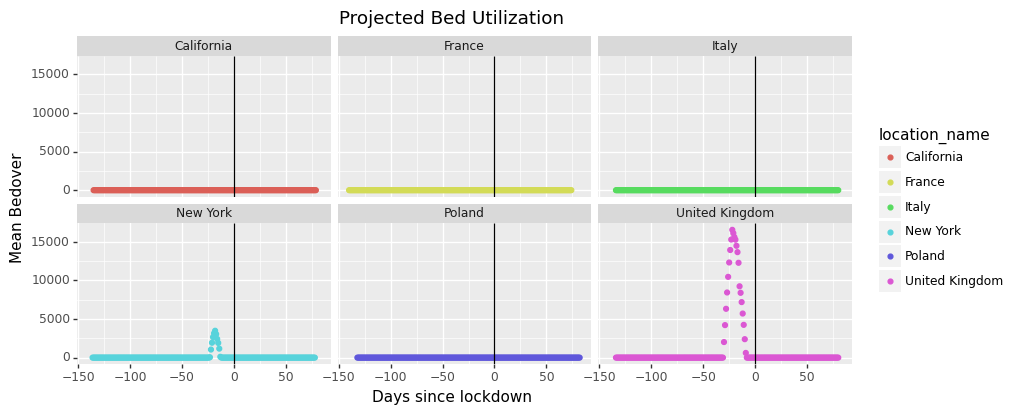

<ggplot: (-9223363301240753713)>

In [0]:
  plotnine.options.figure_size = (10,4)
  (ggplot(infections_df, aes('days_from_lockdown', 'bedover_mean', color='location_name'))
   + geom_point()
   + facet_wrap('~location_name')
   + geom_vline(xintercept=0)
   + labs(x='Days since lockdown',  y='Mean Bedover', title='Projected Bed Utilization')
  )


## Mean Beds needed for Covid cases

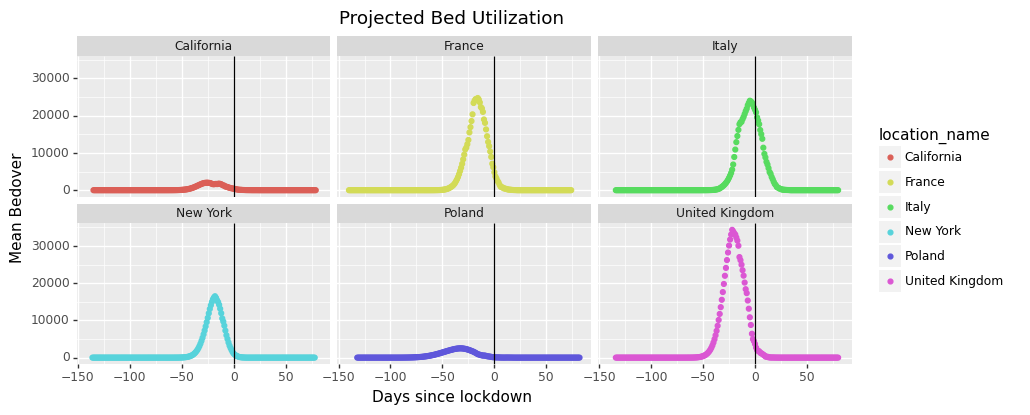

<ggplot: (8735613854472)>

In [0]:
    plotnine.options.figure_size = (10,4)
    (ggplot(infections_df, aes('days_from_lockdown', 'allbed_mean', color='location_name'))
     + geom_point()
     + facet_wrap('~location_name')
     + geom_vline(xintercept=0)
     + labs(x='Days since lockdown',  y='Mean Bedover', title='Projected Bed Utilization')
  )

## Infection Rate

**TODO** Need to edit calculation where little or no data

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 57 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


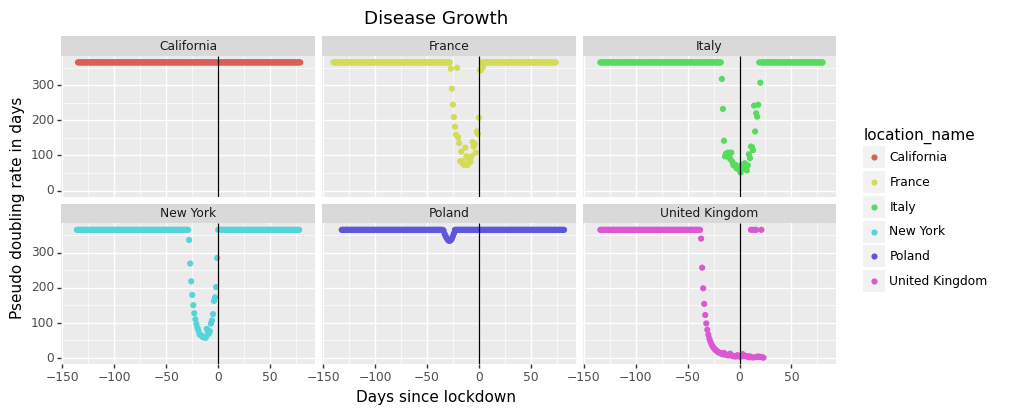

<ggplot: (8735613652558)>

In [0]:
    plotnine.options.figure_size = (10,4)
    (ggplot(infections_df, aes('days_from_lockdown', 'progression', color='location_name'))
     + geom_point()
     + facet_wrap('~location_name')
     + geom_vline(xintercept=0)
     + labs(x='Days since lockdown',  y='Pseudo doubling rate in days', title='Disease Growth' )
  )



# Model

**Approach**

*Simple Model*
The decision to end a lockdown is considered every days from
the initial order. The average hospital admissions across the previous weeks 
are considered. As the number of Covid-related hospital admissions decreases,
the likelihood of suspending the lockdown increases.


*Conditions to consider adding*

* deaths (relative to population)
* deaths (realtive to infected)
* ratio of recovery to newly infected
* % of population has been tested > threshold
* complex priors over dates (1st and 15th of month more likely. Perhaps Holiday's)?
* depletion of susceptible stock 1 - (Infected + Recovered + Deaths) / population > threshold 

*Ad-Hoc High-level features to include*
* Government Market Orientation 
* Government Goal --- Signaling Action | Spread Mitigation  

Model

In [0]:
def model(area: Area, data: pd.core.frame.DataFrame):
  # make sure reasonable things were passed in
  if not "location_name" in data:
    print(f'The data does not have the expected structure')
    raise Exception("bad data")
  elif not area.get("data_key") in data["location_name"].values:
    print(f'There is currently no infection data for {area["data_key"]}')
    raise Exception("no data")
  elif not area.get("start"):
        print(f'There is currently no lockdown for {area["data_key"]}')
        raise Exception("no lockdown")

  # model start
  area_data = data.loc[data["location_name"] == area.get("data_key")] # get data for area
  lockdown_duration = 0
  last_period_spread_rate = max(area_data['admis_mean'])
  while True:
    lockdown_duration += 1
    if (max(area_data['days_from_lockdown']) >= lockdown_duration): # keep using last infection_spread_rate if we run out of data (this is a bad hack)
      # take the average of the hospital admissions for the past five weeks
      infection_spread_rate = np.mean(area_data.loc[(area_data['days_from_lockdown'] > lockdown_duration - 35 ) &
                                                    (area_data['days_from_lockdown'] <= lockdown_duration), 'admis_mean'])

    # This logistic distribution gives the highest probability at 0 and decreases the larger the passed in value. The speed in which the probability drops off is modulated by the scale parameter. The lower the scale parameter, the lower probability assigned to high numbers. Here the .5 indicates a rather thin tail with a strong bias towards low numbers. 
    stop_quarantine = ergo.flip(scipy.stats.logistic.pdf(infection_spread_rate, scale = .5))
    last_period_spread_rate = infection_spread_rate 
    if(stop_quarantine):
        break

  ergo.tag(torch.Tensor([lockdown_duration]), area.get("data_key"))


Run Model

In [0]:
samples = pd.DataFrame() #unconditioned :/ 


for question in questions:
 samples[question.name] = ergo.run(lambda: model(get_assumptions(question), infections_df), num_samples=500).iloc[:,0]



  0%|          | 0/500 [00:00<?, ?it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  1%|          | 3/500 [00:00<01:27,  5.67it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  1%|          | 5/500 [00:00<01:12,  6.79it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  2%|▏         | 9/500 [00:00<00:55,  8.92it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  2%|▏         | 11/500 [00:01<00:49,  9.90it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  3%|▎         | 15/500 [00:01<00:43, 11.03it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  3%|▎         | 17/500 [00:01<00:42, 11.45it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  4%|▍         | 21/500 [00:01<00:39, 12.25it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  5%|▍         | 23/500 [00:01<00:39, 12.00it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  5%|▌         | 27/500 [00:02<00:38, 12.19it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  6%|▌         | 29/500 [00:02<00:38, 12.26it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  7%|▋         | 33/500 [00:02<00:38, 11.98it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  7%|▋         | 35/500 [00:02<00:38, 12.23it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  8%|▊         | 39/500 [00:03<00:37, 12.24it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  8%|▊         | 41/500 [00:03<00:37, 12.24it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  9%|▉         | 45/500 [00:03<00:35, 12.76it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  9%|▉         | 47/500 [00:03<00:35, 12.82it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 10%|█         | 51/500 [00:04<00:34, 12.97it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 11%|█         | 53/500 [00:04<00:34, 12.85it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 11%|█▏        | 57/500 [00:04<00:34, 13.00it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 12%|█▏        | 59/500 [00:04<00:34, 12.93it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 13%|█▎        | 63/500 [00:05<00:32, 13.37it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 13%|█▎        | 65/500 [00:05<00:32, 13.20it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 14%|█▍        | 69/500 [00:05<00:32, 13.29it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 14%|█▍        | 71/500 [00:05<00:32, 13.12it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 15%|█▌        | 75/500 [00:06<00:33, 12.57it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 15%|█▌        | 77/500 [00:06<00:35, 12.05it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 16%|█▌        | 81/500 [00:06<00:33, 12.56it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 17%|█▋        | 83/500 [00:06<00:33, 12.37it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 17%|█▋        | 87/500 [00:07<00:33, 12.31it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 18%|█▊        | 89/500 [00:07<00:33, 12.22it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 19%|█▊        | 93/500 [00:07<00:32, 12.45it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 19%|█▉        | 95/500 [00:07<00:31, 12.75it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 20%|█▉        | 99/500 [00:07<00:31, 12.91it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 20%|██        | 101/500 [00:08<00:30, 13.02it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 21%|██        | 105/500 [00:08<00:30, 12.94it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 21%|██▏       | 107/500 [00:08<00:30, 12.95it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 22%|██▏       | 111/500 [00:08<00:30, 12.87it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 23%|██▎       | 113/500 [00:09<00:29, 12.91it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 23%|██▎       | 117/500 [00:09<00:30, 12.76it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 24%|██▍       | 119/500 [00:09<00:29, 12.78it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 25%|██▍       | 123/500 [00:09<00:29, 12.73it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 25%|██▌       | 125/500 [00:10<00:29, 12.61it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 26%|██▌       | 129/500 [00:10<00:29, 12.46it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 26%|██▌       | 131/500 [00:10<00:29, 12.37it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 27%|██▋       | 135/500 [00:10<00:28, 12.73it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 27%|██▋       | 137/500 [00:10<00:28, 12.64it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 28%|██▊       | 141/500 [00:11<00:28, 12.80it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 29%|██▊       | 143/500 [00:11<00:27, 12.96it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 29%|██▉       | 147/500 [00:11<00:27, 13.00it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 30%|██▉       | 149/500 [00:11<00:26, 13.04it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 31%|███       | 153/500 [00:12<00:27, 12.57it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 31%|███       | 155/500 [00:12<00:27, 12.41it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 32%|███▏      | 159/500 [00:12<00:27, 12.29it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 32%|███▏      | 161/500 [00:12<00:28, 12.05it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 33%|███▎      | 165/500 [00:13<00:27, 12.28it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 33%|███▎      | 167/500 [00:13<00:26, 12.38it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 34%|███▍      | 171/500 [00:13<00:26, 12.57it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 35%|███▍      | 173/500 [00:13<00:25, 12.59it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 35%|███▌      | 177/500 [00:14<00:25, 12.82it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 36%|███▌      | 179/500 [00:14<00:25, 12.43it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 37%|███▋      | 183/500 [00:14<00:25, 12.54it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 37%|███▋      | 185/500 [00:14<00:25, 12.31it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 38%|███▊      | 189/500 [00:15<00:24, 12.45it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 38%|███▊      | 191/500 [00:15<00:25, 12.33it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 39%|███▉      | 195/500 [00:15<00:23, 12.79it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 39%|███▉      | 197/500 [00:15<00:23, 12.73it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 40%|████      | 201/500 [00:16<00:23, 12.91it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 41%|████      | 203/500 [00:16<00:23, 12.79it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 41%|████▏     | 207/500 [00:16<00:23, 12.50it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 42%|████▏     | 209/500 [00:16<00:22, 12.73it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 43%|████▎     | 213/500 [00:17<00:22, 12.85it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 43%|████▎     | 215/500 [00:17<00:21, 13.18it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 44%|████▍     | 219/500 [00:17<00:21, 13.13it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 44%|████▍     | 221/500 [00:17<00:21, 13.27it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 45%|████▌     | 225/500 [00:17<00:20, 13.26it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 45%|████▌     | 227/500 [00:18<00:20, 13.17it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 46%|████▌     | 231/500 [00:18<00:20, 13.07it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 47%|████▋     | 233/500 [00:18<00:20, 13.01it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 47%|████▋     | 237/500 [00:18<00:19, 13.32it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 48%|████▊     | 239/500 [00:18<00:19, 13.21it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 49%|████▊     | 243/500 [00:19<00:19, 13.03it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 49%|████▉     | 245/500 [00:19<00:19, 12.83it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 50%|████▉     | 249/500 [00:19<00:19, 12.92it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 50%|█████     | 251/500 [00:19<00:19, 12.56it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 51%|█████     | 255/500 [00:20<00:19, 12.52it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 51%|█████▏    | 257/500 [00:20<00:19, 12.22it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 52%|█████▏    | 261/500 [00:20<00:19, 12.49it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 53%|█████▎    | 263/500 [00:20<00:18, 12.48it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 53%|█████▎    | 267/500 [00:21<00:18, 12.49it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 54%|█████▍    | 269/500 [00:21<00:18, 12.40it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 55%|█████▍    | 273/500 [00:21<00:18, 11.96it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 55%|█████▌    | 275/500 [00:21<00:18, 12.14it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 56%|█████▌    | 279/500 [00:22<00:17, 12.47it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 56%|█████▌    | 281/500 [00:22<00:17, 12.26it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 57%|█████▋    | 285/500 [00:22<00:17, 12.15it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 57%|█████▋    | 287/500 [00:22<00:17, 12.32it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 58%|█████▊    | 291/500 [00:23<00:17, 12.19it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 59%|█████▊    | 293/500 [00:23<00:17, 12.11it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 59%|█████▉    | 297/500 [00:23<00:16, 12.52it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 60%|█████▉    | 299/500 [00:23<00:16, 12.34it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 61%|██████    | 303/500 [00:24<00:15, 12.35it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 61%|██████    | 305/500 [00:24<00:15, 12.26it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 62%|██████▏   | 309/500 [00:24<00:15, 12.26it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 62%|██████▏   | 311/500 [00:24<00:15, 12.11it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 63%|██████▎   | 315/500 [00:25<00:14, 12.52it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 63%|██████▎   | 317/500 [00:25<00:14, 12.72it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 64%|██████▍   | 321/500 [00:25<00:14, 12.77it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 65%|██████▍   | 323/500 [00:25<00:13, 13.07it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 65%|██████▌   | 327/500 [00:26<00:13, 13.20it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 66%|██████▌   | 329/500 [00:26<00:13, 13.03it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 67%|██████▋   | 333/500 [00:26<00:13, 12.29it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 67%|██████▋   | 335/500 [00:26<00:13, 12.44it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 68%|██████▊   | 339/500 [00:27<00:12, 12.76it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 68%|██████▊   | 341/500 [00:27<00:12, 12.84it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 69%|██████▉   | 345/500 [00:27<00:12, 12.84it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 69%|██████▉   | 347/500 [00:27<00:12, 12.69it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 70%|███████   | 351/500 [00:27<00:11, 12.96it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 71%|███████   | 353/500 [00:28<00:11, 13.02it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 71%|███████▏  | 357/500 [00:28<00:10, 13.32it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 72%|███████▏  | 359/500 [00:28<00:10, 12.97it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 73%|███████▎  | 363/500 [00:28<00:10, 13.10it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 73%|███████▎  | 365/500 [00:29<00:10, 12.87it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 74%|███████▍  | 369/500 [00:29<00:10, 13.09it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 74%|███████▍  | 371/500 [00:29<00:10, 12.36it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 75%|███████▌  | 375/500 [00:29<00:10, 12.42it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 75%|███████▌  | 377/500 [00:30<00:10, 12.16it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 76%|███████▌  | 381/500 [00:30<00:09, 12.68it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 77%|███████▋  | 383/500 [00:30<00:09, 12.78it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 77%|███████▋  | 387/500 [00:30<00:08, 12.75it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 78%|███████▊  | 389/500 [00:30<00:08, 12.57it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 79%|███████▊  | 393/500 [00:31<00:08, 12.96it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 79%|███████▉  | 395/500 [00:31<00:08, 12.93it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 80%|███████▉  | 399/500 [00:31<00:07, 13.02it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 80%|████████  | 401/500 [00:31<00:07, 12.68it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 81%|████████  | 405/500 [00:32<00:07, 12.31it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 81%|████████▏ | 407/500 [00:32<00:07, 12.52it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 82%|████████▏ | 411/500 [00:32<00:06, 12.78it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 83%|████████▎ | 413/500 [00:32<00:06, 12.51it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 83%|████████▎ | 417/500 [00:33<00:06, 12.71it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 84%|████████▍ | 419/500 [00:33<00:06, 12.69it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 85%|████████▍ | 423/500 [00:33<00:05, 12.87it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 85%|████████▌ | 425/500 [00:33<00:05, 13.00it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 86%|████████▌ | 429/500 [00:34<00:05, 13.10it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 86%|████████▌ | 431/500 [00:34<00:05, 12.67it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 87%|████████▋ | 435/500 [00:34<00:05, 12.22it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 87%|████████▋ | 437/500 [00:34<00:05, 12.02it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 88%|████████▊ | 441/500 [00:35<00:04, 12.05it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 89%|████████▊ | 443/500 [00:35<00:04, 12.28it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 89%|████████▉ | 447/500 [00:35<00:04, 12.56it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 90%|████████▉ | 449/500 [00:35<00:04, 12.45it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 91%|█████████ | 453/500 [00:36<00:03, 12.47it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 91%|█████████ | 455/500 [00:36<00:03, 12.82it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 92%|█████████▏| 459/500 [00:36<00:03, 12.96it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 92%|█████████▏| 461/500 [00:36<00:03, 12.89it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 93%|█████████▎| 465/500 [00:36<00:02, 12.83it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 93%|█████████▎| 467/500 [00:37<00:02, 12.87it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 94%|█████████▍| 471/500 [00:37<00:02, 12.54it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 95%|█████████▍| 473/500 [00:37<00:02, 12.70it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 95%|█████████▌| 477/500 [00:37<00:01, 12.56it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 96%|█████████▌| 479/500 [00:38<00:01, 12.51it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 97%|█████████▋| 483/500 [00:38<00:01, 12.68it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 97%|█████████▋| 485/500 [00:38<00:01, 12.75it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 98%|█████████▊| 489/500 [00:38<00:00, 12.58it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 98%|█████████▊| 491/500 [00:39<00:00, 12.53it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 99%|█████████▉| 495/500 [00:39<00:00, 12.72it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


 99%|█████████▉| 497/500 [00:39<00:00, 12.88it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom


  0%|          | 0/500 [00:00<?, ?it/s]

No assumptions for question: The United Kingdom
No assumptions for question: The United Kingdom
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  1%|          | 4/500 [00:00<00:40, 12.13it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  1%|          | 6/500 [00:00<00:40, 12.11it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  2%|▏         | 10/500 [00:00<00:39, 12.39it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  2%|▏         | 12/500 [00:00<00:40, 12.14it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  3%|▎         | 16/500 [00:01<00:39, 12.18it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  4%|▎         | 18/500 [00:01<00:39, 12.24it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  4%|▍         | 22/500 [00:01<00:38, 12.28it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  5%|▍         | 24/500 [00:01<00:39, 11.92it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  6%|▌         | 28/500 [00:02<00:39, 11.85it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  6%|▌         | 30/500 [00:02<00:39, 11.76it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  7%|▋         | 34/500 [00:02<00:38, 12.17it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  7%|▋         | 36/500 [00:02<00:39, 11.89it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  8%|▊         | 40/500 [00:03<00:38, 11.89it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  8%|▊         | 42/500 [00:03<00:38, 11.91it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  9%|▉         | 46/500 [00:03<00:36, 12.42it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 10%|▉         | 48/500 [00:03<00:36, 12.44it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 10%|█         | 52/500 [00:04<00:36, 12.17it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 11%|█         | 54/500 [00:04<00:36, 12.14it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 12%|█▏        | 58/500 [00:04<00:35, 12.36it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 12%|█▏        | 60/500 [00:04<00:35, 12.47it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 13%|█▎        | 64/500 [00:05<00:35, 12.15it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 13%|█▎        | 66/500 [00:05<00:35, 12.11it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 14%|█▍        | 70/500 [00:05<00:35, 12.24it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 14%|█▍        | 72/500 [00:05<00:35, 12.13it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 15%|█▌        | 76/500 [00:06<00:35, 11.92it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 16%|█▌        | 78/500 [00:06<00:34, 12.08it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 16%|█▋        | 82/500 [00:06<00:34, 12.16it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 17%|█▋        | 84/500 [00:06<00:33, 12.26it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 18%|█▊        | 88/500 [00:07<00:33, 12.26it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 18%|█▊        | 90/500 [00:07<00:33, 12.10it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 19%|█▉        | 94/500 [00:07<00:34, 11.72it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 19%|█▉        | 96/500 [00:07<00:33, 11.99it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 20%|██        | 100/500 [00:08<00:33, 12.01it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 20%|██        | 102/500 [00:08<00:33, 12.04it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 21%|██        | 106/500 [00:08<00:32, 12.14it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 22%|██▏       | 108/500 [00:08<00:32, 12.24it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 22%|██▏       | 112/500 [00:09<00:31, 12.19it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 23%|██▎       | 114/500 [00:09<00:31, 12.19it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 24%|██▎       | 118/500 [00:09<00:31, 12.27it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 24%|██▍       | 120/500 [00:09<00:31, 12.17it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 25%|██▍       | 124/500 [00:10<00:31, 11.86it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 25%|██▌       | 126/500 [00:10<00:31, 11.94it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 26%|██▌       | 130/500 [00:10<00:31, 11.89it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 26%|██▋       | 132/500 [00:10<00:30, 12.09it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 27%|██▋       | 136/500 [00:11<00:29, 12.26it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 28%|██▊       | 138/500 [00:11<00:29, 12.14it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 28%|██▊       | 142/500 [00:11<00:29, 12.30it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 29%|██▉       | 144/500 [00:11<00:29, 12.23it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 30%|██▉       | 148/500 [00:12<00:28, 12.14it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 30%|███       | 150/500 [00:12<00:28, 12.15it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 31%|███       | 154/500 [00:12<00:28, 12.09it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 31%|███       | 156/500 [00:12<00:28, 11.94it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 32%|███▏      | 160/500 [00:13<00:29, 11.62it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 32%|███▏      | 162/500 [00:13<00:28, 11.67it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 33%|███▎      | 166/500 [00:13<00:28, 11.89it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 34%|███▎      | 168/500 [00:13<00:27, 12.06it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 34%|███▍      | 172/500 [00:14<00:27, 11.97it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 35%|███▍      | 174/500 [00:14<00:27, 11.79it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 36%|███▌      | 178/500 [00:14<00:27, 11.86it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 36%|███▌      | 180/500 [00:14<00:26, 12.01it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 37%|███▋      | 184/500 [00:15<00:26, 11.80it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 37%|███▋      | 186/500 [00:15<00:26, 11.81it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 38%|███▊      | 190/500 [00:15<00:25, 12.12it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 38%|███▊      | 192/500 [00:15<00:25, 12.25it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 39%|███▉      | 196/500 [00:16<00:25, 12.09it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 40%|███▉      | 198/500 [00:16<00:24, 12.09it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 40%|████      | 202/500 [00:16<00:24, 11.96it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 41%|████      | 204/500 [00:16<00:24, 12.19it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 42%|████▏     | 208/500 [00:17<00:24, 12.01it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 42%|████▏     | 210/500 [00:17<00:24, 11.95it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 43%|████▎     | 214/500 [00:17<00:23, 12.35it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 43%|████▎     | 216/500 [00:17<00:22, 12.35it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 44%|████▍     | 220/500 [00:18<00:23, 11.95it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 44%|████▍     | 222/500 [00:18<00:23, 11.71it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 45%|████▌     | 226/500 [00:18<00:23, 11.86it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 46%|████▌     | 228/500 [00:18<00:22, 11.86it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 46%|████▋     | 232/500 [00:19<00:22, 12.00it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 47%|████▋     | 234/500 [00:19<00:22, 12.06it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 48%|████▊     | 238/500 [00:19<00:22, 11.81it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 48%|████▊     | 240/500 [00:19<00:22, 11.55it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 49%|████▉     | 244/500 [00:20<00:22, 11.20it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 49%|████▉     | 246/500 [00:20<00:22, 11.32it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 50%|█████     | 250/500 [00:20<00:21, 11.38it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 50%|█████     | 252/500 [00:21<00:21, 11.66it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 51%|█████     | 256/500 [00:21<00:20, 11.82it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 52%|█████▏    | 258/500 [00:21<00:20, 11.94it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 52%|█████▏    | 262/500 [00:21<00:19, 12.13it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 53%|█████▎    | 264/500 [00:22<00:19, 12.02it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 54%|█████▎    | 268/500 [00:22<00:19, 12.07it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 54%|█████▍    | 270/500 [00:22<00:18, 12.29it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 55%|█████▍    | 274/500 [00:22<00:18, 12.00it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 55%|█████▌    | 276/500 [00:23<00:18, 11.88it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 56%|█████▌    | 280/500 [00:23<00:18, 11.95it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 56%|█████▋    | 282/500 [00:23<00:18, 11.82it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 57%|█████▋    | 286/500 [00:23<00:17, 11.92it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 58%|█████▊    | 288/500 [00:24<00:17, 11.88it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 58%|█████▊    | 292/500 [00:24<00:17, 12.04it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 59%|█████▉    | 294/500 [00:24<00:17, 11.99it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 60%|█████▉    | 298/500 [00:24<00:16, 12.22it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 60%|██████    | 300/500 [00:25<00:16, 12.04it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 61%|██████    | 304/500 [00:25<00:16, 11.93it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 61%|██████    | 306/500 [00:25<00:16, 11.78it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 62%|██████▏   | 310/500 [00:25<00:16, 11.56it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 62%|██████▏   | 312/500 [00:26<00:16, 11.61it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 63%|██████▎   | 316/500 [00:26<00:15, 11.53it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 64%|██████▎   | 318/500 [00:26<00:15, 11.68it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 64%|██████▍   | 322/500 [00:26<00:15, 11.84it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 65%|██████▍   | 324/500 [00:27<00:14, 11.83it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 66%|██████▌   | 328/500 [00:27<00:14, 12.20it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 66%|██████▌   | 330/500 [00:27<00:13, 12.19it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 67%|██████▋   | 334/500 [00:27<00:13, 11.89it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 67%|██████▋   | 336/500 [00:28<00:13, 12.04it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 68%|██████▊   | 340/500 [00:28<00:13, 12.00it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 68%|██████▊   | 342/500 [00:28<00:13, 11.92it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 69%|██████▉   | 346/500 [00:28<00:13, 11.70it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 70%|██████▉   | 348/500 [00:29<00:13, 11.65it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 70%|███████   | 352/500 [00:29<00:12, 11.91it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 71%|███████   | 354/500 [00:29<00:12, 11.81it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 72%|███████▏  | 358/500 [00:29<00:11, 11.97it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 72%|███████▏  | 360/500 [00:30<00:11, 12.03it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 73%|███████▎  | 364/500 [00:30<00:11, 11.97it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 73%|███████▎  | 366/500 [00:30<00:11, 11.97it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 74%|███████▍  | 370/500 [00:30<00:10, 12.20it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 74%|███████▍  | 372/500 [00:31<00:10, 11.97it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 75%|███████▌  | 376/500 [00:31<00:10, 12.04it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 76%|███████▌  | 378/500 [00:31<00:10, 12.05it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 76%|███████▋  | 382/500 [00:31<00:09, 12.41it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 77%|███████▋  | 384/500 [00:32<00:09, 12.25it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 78%|███████▊  | 388/500 [00:32<00:09, 11.85it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 78%|███████▊  | 390/500 [00:32<00:09, 11.69it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 79%|███████▉  | 394/500 [00:32<00:08, 12.23it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 79%|███████▉  | 396/500 [00:33<00:08, 12.33it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 80%|████████  | 400/500 [00:33<00:07, 12.58it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 80%|████████  | 402/500 [00:33<00:07, 12.39it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 81%|████████  | 406/500 [00:33<00:07, 12.21it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 82%|████████▏ | 408/500 [00:34<00:07, 12.36it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 82%|████████▏ | 412/500 [00:34<00:07, 12.42it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 83%|████████▎ | 414/500 [00:34<00:07, 11.94it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 84%|████████▎ | 418/500 [00:34<00:06, 11.93it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 84%|████████▍ | 420/500 [00:35<00:06, 11.99it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 85%|████████▍ | 424/500 [00:35<00:06, 12.41it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 85%|████████▌ | 426/500 [00:35<00:06, 12.15it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 86%|████████▌ | 430/500 [00:35<00:05, 12.06it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 86%|████████▋ | 432/500 [00:36<00:05, 12.04it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 87%|████████▋ | 436/500 [00:36<00:05, 11.53it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 88%|████████▊ | 438/500 [00:36<00:05, 11.62it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 88%|████████▊ | 442/500 [00:36<00:04, 11.83it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 89%|████████▉ | 444/500 [00:37<00:04, 11.76it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 90%|████████▉ | 448/500 [00:37<00:04, 11.82it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 90%|█████████ | 450/500 [00:37<00:04, 11.73it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 91%|█████████ | 454/500 [00:37<00:03, 12.15it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 91%|█████████ | 456/500 [00:38<00:03, 12.49it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 92%|█████████▏| 460/500 [00:38<00:03, 12.38it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 92%|█████████▏| 462/500 [00:38<00:03, 12.43it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 93%|█████████▎| 466/500 [00:38<00:02, 12.12it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 94%|█████████▎| 468/500 [00:39<00:02, 12.11it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 94%|█████████▍| 472/500 [00:39<00:02, 12.29it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 95%|█████████▍| 474/500 [00:39<00:02, 12.40it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 96%|█████████▌| 478/500 [00:39<00:01, 12.35it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 96%|█████████▌| 480/500 [00:39<00:01, 12.39it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 97%|█████████▋| 484/500 [00:40<00:01, 11.99it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 97%|█████████▋| 486/500 [00:40<00:01, 12.04it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 98%|█████████▊| 490/500 [00:40<00:00, 12.22it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 98%|█████████▊| 492/500 [00:40<00:00, 12.07it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


 99%|█████████▉| 496/500 [00:41<00:00, 12.04it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


100%|█████████▉| 498/500 [00:41<00:00, 12.09it/s]

No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France
No assumptions for question: France


  0%|          | 2/500 [00:00<00:32, 15.36it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  1%|          | 6/500 [00:00<00:32, 15.23it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  2%|▏         | 10/500 [00:00<00:32, 15.17it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  3%|▎         | 14/500 [00:00<00:33, 14.34it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  4%|▎         | 18/500 [00:01<00:32, 14.86it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  4%|▍         | 22/500 [00:01<00:33, 14.20it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  5%|▍         | 24/500 [00:01<00:33, 14.29it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  6%|▌         | 28/500 [00:01<00:32, 14.55it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  6%|▋         | 32/500 [00:02<00:31, 14.92it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  7%|▋         | 36/500 [00:02<00:31, 14.83it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  8%|▊         | 40/500 [00:02<00:31, 14.76it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  8%|▊         | 42/500 [00:02<00:31, 14.55it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  9%|▉         | 46/500 [00:03<00:31, 14.57it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 10%|█         | 50/500 [00:03<00:31, 14.49it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 11%|█         | 54/500 [00:03<00:30, 14.49it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland

 12%|█▏        | 58/500 [00:03<00:30, 14.61it/s]


No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 12%|█▏        | 60/500 [00:04<00:29, 14.71it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 13%|█▎        | 64/500 [00:04<00:30, 14.49it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 14%|█▎        | 68/500 [00:04<00:28, 15.08it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 14%|█▍        | 72/500 [00:04<00:27, 15.70it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 15%|█▌        | 76/500 [00:05<00:26, 15.77it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 16%|█▌        | 80/500 [00:05<00:26, 15.74it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 17%|█▋        | 84/500 [00:05<00:26, 15.90it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 18%|█▊        | 88/500 [00:05<00:26, 15.71it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 18%|█▊        | 92/500 [00:06<00:26, 15.30it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 19%|█▉        | 96/500 [00:06<00:26, 15.11it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 20%|██        | 100/500 [00:06<00:26, 15.32it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 20%|██        | 102/500 [00:06<00:27, 14.65it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 21%|██        | 106/500 [00:07<00:26, 14.72it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 22%|██▏       | 110/500 [00:07<00:25, 15.22it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 23%|██▎       | 114/500 [00:07<00:25, 15.06it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 24%|██▎       | 118/500 [00:07<00:25, 15.05it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 24%|██▍       | 122/500 [00:08<00:25, 14.81it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 25%|██▍       | 124/500 [00:08<00:25, 14.57it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 26%|██▌       | 128/500 [00:08<00:25, 14.68it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 26%|██▋       | 132/500 [00:08<00:25, 14.20it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 27%|██▋       | 136/500 [00:09<00:24, 14.59it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 28%|██▊       | 140/500 [00:09<00:23, 15.11it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 29%|██▉       | 144/500 [00:09<00:24, 14.80it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 29%|██▉       | 146/500 [00:09<00:23, 14.95it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 30%|███       | 150/500 [00:10<00:23, 14.70it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 31%|███       | 154/500 [00:10<00:23, 14.42it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 31%|███       | 156/500 [00:10<00:24, 14.21it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 32%|███▏      | 160/500 [00:10<00:23, 14.55it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 33%|███▎      | 164/500 [00:11<00:22, 14.62it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 33%|███▎      | 166/500 [00:11<00:23, 14.44it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 34%|███▍      | 170/500 [00:11<00:23, 14.06it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 35%|███▍      | 174/500 [00:11<00:22, 14.68it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 36%|███▌      | 178/500 [00:12<00:22, 14.60it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 36%|███▋      | 182/500 [00:12<00:21, 14.75it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 37%|███▋      | 186/500 [00:12<00:21, 14.79it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 38%|███▊      | 190/500 [00:12<00:20, 14.81it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 39%|███▉      | 194/500 [00:13<00:20, 14.61it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 40%|███▉      | 198/500 [00:13<00:19, 15.21it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 40%|████      | 200/500 [00:13<00:20, 14.99it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 41%|████      | 204/500 [00:13<00:19, 14.95it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 42%|████▏     | 208/500 [00:14<00:20, 14.57it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 42%|████▏     | 210/500 [00:14<00:19, 14.66it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 43%|████▎     | 214/500 [00:14<00:19, 14.52it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 44%|████▎     | 218/500 [00:14<00:19, 14.62it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 44%|████▍     | 222/500 [00:15<00:18, 14.73it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 45%|████▍     | 224/500 [00:15<00:19, 14.39it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 46%|████▌     | 228/500 [00:15<00:18, 14.71it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 46%|████▋     | 232/500 [00:15<00:17, 15.19it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 47%|████▋     | 236/500 [00:15<00:17, 15.50it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 48%|████▊     | 240/500 [00:16<00:17, 15.27it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 49%|████▉     | 244/500 [00:16<00:16, 15.13it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 50%|████▉     | 248/500 [00:16<00:16, 14.90it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 50%|█████     | 250/500 [00:16<00:16, 14.90it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 51%|█████     | 254/500 [00:17<00:16, 14.69it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 52%|█████▏    | 258/500 [00:17<00:16, 14.65it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 52%|█████▏    | 262/500 [00:17<00:15, 15.12it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 53%|█████▎    | 264/500 [00:17<00:16, 14.62it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 54%|█████▎    | 268/500 [00:18<00:15, 14.56it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 54%|█████▍    | 272/500 [00:18<00:15, 14.71it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 55%|█████▌    | 276/500 [00:18<00:14, 15.16it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 56%|█████▌    | 280/500 [00:18<00:14, 15.08it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 57%|█████▋    | 284/500 [00:19<00:14, 15.18it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 58%|█████▊    | 288/500 [00:19<00:14, 14.80it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 58%|█████▊    | 292/500 [00:19<00:13, 14.94it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 59%|█████▉    | 296/500 [00:20<00:13, 15.13it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 60%|██████    | 300/500 [00:20<00:13, 15.08it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 60%|██████    | 302/500 [00:20<00:13, 14.68it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 61%|██████    | 306/500 [00:20<00:13, 14.51it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 62%|██████▏   | 310/500 [00:20<00:12, 14.99it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 63%|██████▎   | 314/500 [00:21<00:12, 14.91it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 64%|██████▎   | 318/500 [00:21<00:12, 15.10it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 64%|██████▍   | 322/500 [00:21<00:12, 13.93it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 65%|██████▌   | 326/500 [00:22<00:11, 14.64it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 66%|██████▌   | 328/500 [00:22<00:11, 14.46it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 66%|██████▋   | 332/500 [00:22<00:11, 14.41it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 67%|██████▋   | 336/500 [00:22<00:11, 14.62it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 68%|██████▊   | 340/500 [00:23<00:10, 14.68it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 69%|██████▉   | 344/500 [00:23<00:10, 14.74it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 70%|██████▉   | 348/500 [00:23<00:10, 15.01it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 70%|███████   | 350/500 [00:23<00:10, 14.76it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 71%|███████   | 354/500 [00:23<00:09, 15.37it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 72%|███████▏  | 358/500 [00:24<00:09, 14.72it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 72%|███████▏  | 362/500 [00:24<00:09, 14.94it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 73%|███████▎  | 366/500 [00:24<00:08, 15.01it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 74%|███████▍  | 370/500 [00:25<00:08, 15.22it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 75%|███████▍  | 374/500 [00:25<00:08, 14.95it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 76%|███████▌  | 378/500 [00:25<00:08, 15.03it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 76%|███████▋  | 382/500 [00:25<00:07, 15.24it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 77%|███████▋  | 386/500 [00:26<00:07, 14.80it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 78%|███████▊  | 390/500 [00:26<00:07, 14.63it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 79%|███████▉  | 394/500 [00:26<00:07, 14.66it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 79%|███████▉  | 396/500 [00:26<00:07, 14.61it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 80%|████████  | 400/500 [00:27<00:06, 14.75it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 81%|████████  | 404/500 [00:27<00:06, 15.21it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 82%|████████▏ | 408/500 [00:27<00:06, 15.33it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 82%|████████▏ | 412/500 [00:27<00:05, 14.86it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 83%|████████▎ | 414/500 [00:27<00:05, 14.76it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 84%|████████▎ | 418/500 [00:28<00:05, 14.35it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 84%|████████▍ | 422/500 [00:28<00:05, 14.71it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 85%|████████▌ | 426/500 [00:28<00:04, 15.07it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 86%|████████▌ | 430/500 [00:29<00:04, 14.98it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 87%|████████▋ | 434/500 [00:29<00:04, 15.03it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 88%|████████▊ | 438/500 [00:29<00:03, 15.59it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 88%|████████▊ | 440/500 [00:29<00:03, 15.35it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 89%|████████▉ | 444/500 [00:30<00:03, 14.91it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 89%|████████▉ | 446/500 [00:30<00:03, 14.74it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 90%|█████████ | 450/500 [00:30<00:03, 14.63it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 91%|█████████ | 454/500 [00:30<00:03, 15.07it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 92%|█████████▏| 458/500 [00:30<00:02, 15.43it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 92%|█████████▏| 462/500 [00:31<00:02, 15.35it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 93%|█████████▎| 466/500 [00:31<00:02, 14.96it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 94%|█████████▍| 470/500 [00:31<00:01, 15.59it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 95%|█████████▍| 474/500 [00:31<00:01, 15.31it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 95%|█████████▌| 476/500 [00:32<00:01, 15.20it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 96%|█████████▌| 480/500 [00:32<00:01, 14.63it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 97%|█████████▋| 484/500 [00:32<00:01, 14.81it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland

 97%|█████████▋| 486/500 [00:32<00:00, 14.30it/s]


No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 98%|█████████▊| 490/500 [00:33<00:00, 14.49it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


 99%|█████████▉| 494/500 [00:33<00:00, 14.68it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


100%|█████████▉| 498/500 [00:33<00:00, 14.66it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland


  0%|          | 0/500 [00:00<?, ?it/s]

No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: Poland
No assumptions for question: The State of California
No assumptions for question: The State of California


  1%|          | 4/500 [00:00<00:36, 13.62it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  2%|▏         | 8/500 [00:00<00:34, 14.06it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  2%|▏         | 10/500 [00:00<00:35, 13.77it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  3%|▎         | 14/500 [00:01<00:35, 13.56it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  3%|▎         | 16/500 [00:01<00:35, 13.49it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  4%|▍         | 20/500 [00:01<00:36, 13.25it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  4%|▍         | 22/500 [00:01<00:35, 13.34it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  5%|▌         | 26/500 [00:01<00:35, 13.46it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  6%|▌         | 28/500 [00:02<00:35, 13.29it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  6%|▋         | 32/500 [00:02<00:35, 13.35it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  7%|▋         | 34/500 [00:02<00:36, 12.85it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  8%|▊         | 38/500 [00:02<00:34, 13.29it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  8%|▊         | 40/500 [00:02<00:34, 13.18it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  9%|▉         | 44/500 [00:03<00:34, 13.32it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  9%|▉         | 46/500 [00:03<00:33, 13.41it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 10%|█         | 50/500 [00:03<00:32, 13.89it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 10%|█         | 52/500 [00:03<00:32, 13.66it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 11%|█         | 56/500 [00:04<00:32, 13.73it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 12%|█▏        | 58/500 [00:04<00:32, 13.50it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 12%|█▏        | 62/500 [00:04<00:32, 13.65it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 13%|█▎        | 64/500 [00:04<00:32, 13.57it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 14%|█▎        | 68/500 [00:05<00:30, 14.20it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 14%|█▍        | 72/500 [00:05<00:29, 14.33it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 15%|█▌        | 76/500 [00:05<00:29, 14.20it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 16%|█▌        | 78/500 [00:05<00:29, 14.08it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 16%|█▋        | 82/500 [00:06<00:30, 13.77it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 17%|█▋        | 84/500 [00:06<00:30, 13.85it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 18%|█▊        | 88/500 [00:06<00:29, 13.76it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 18%|█▊        | 92/500 [00:06<00:28, 14.11it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 19%|█▉        | 94/500 [00:06<00:28, 14.05it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 20%|█▉        | 98/500 [00:07<00:29, 13.71it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 20%|██        | 100/500 [00:07<00:29, 13.73it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 21%|██        | 104/500 [00:07<00:29, 13.35it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 21%|██        | 106/500 [00:07<00:28, 13.68it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 22%|██▏       | 110/500 [00:08<00:28, 13.58it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 22%|██▏       | 112/500 [00:08<00:27, 13.91it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 23%|██▎       | 116/500 [00:08<00:28, 13.68it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 24%|██▎       | 118/500 [00:08<00:28, 13.53it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 24%|██▍       | 122/500 [00:08<00:29, 13.03it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 25%|██▍       | 124/500 [00:09<00:28, 13.41it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 26%|██▌       | 128/500 [00:09<00:26, 13.83it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 26%|██▌       | 130/500 [00:09<00:27, 13.69it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 27%|██▋       | 134/500 [00:09<00:26, 13.86it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 27%|██▋       | 136/500 [00:09<00:26, 13.93it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 28%|██▊       | 140/500 [00:10<00:25, 13.97it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 28%|██▊       | 142/500 [00:10<00:25, 14.07it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 29%|██▉       | 146/500 [00:10<00:25, 13.81it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 30%|██▉       | 148/500 [00:10<00:25, 13.83it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 30%|███       | 152/500 [00:11<00:25, 13.71it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 31%|███       | 154/500 [00:11<00:25, 13.78it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 32%|███▏      | 158/500 [00:11<00:24, 13.77it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 32%|███▏      | 160/500 [00:11<00:24, 13.65it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 33%|███▎      | 164/500 [00:11<00:24, 13.93it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 34%|███▎      | 168/500 [00:12<00:23, 14.32it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 34%|███▍      | 170/500 [00:12<00:23, 14.17it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 35%|███▍      | 174/500 [00:12<00:23, 14.11it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 35%|███▌      | 176/500 [00:12<00:22, 14.23it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 36%|███▌      | 180/500 [00:13<00:22, 13.92it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 36%|███▋      | 182/500 [00:13<00:22, 13.98it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 37%|███▋      | 186/500 [00:13<00:22, 13.90it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 38%|███▊      | 190/500 [00:13<00:21, 14.12it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 38%|███▊      | 192/500 [00:13<00:22, 13.84it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 39%|███▉      | 196/500 [00:14<00:22, 13.76it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 40%|███▉      | 198/500 [00:14<00:22, 13.67it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 40%|████      | 202/500 [00:14<00:21, 13.75it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 41%|████      | 204/500 [00:14<00:21, 13.96it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 42%|████▏     | 208/500 [00:15<00:21, 13.89it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 42%|████▏     | 210/500 [00:15<00:20, 13.82it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 43%|████▎     | 214/500 [00:15<00:20, 13.74it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 43%|████▎     | 216/500 [00:15<00:21, 13.52it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 44%|████▍     | 220/500 [00:16<00:20, 13.65it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 45%|████▍     | 224/500 [00:16<00:19, 14.04it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 45%|████▌     | 226/500 [00:16<00:19, 13.71it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 46%|████▌     | 230/500 [00:16<00:19, 13.96it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 46%|████▋     | 232/500 [00:16<00:19, 14.02it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 47%|████▋     | 236/500 [00:17<00:19, 13.70it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 48%|████▊     | 238/500 [00:17<00:19, 13.60it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 48%|████▊     | 242/500 [00:17<00:18, 13.65it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 49%|████▉     | 244/500 [00:17<00:18, 13.72it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 50%|████▉     | 248/500 [00:18<00:18, 13.43it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 50%|█████     | 250/500 [00:18<00:18, 13.56it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 51%|█████     | 254/500 [00:18<00:18, 13.65it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 51%|█████     | 256/500 [00:18<00:17, 13.75it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 52%|█████▏    | 260/500 [00:18<00:17, 13.80it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 53%|█████▎    | 264/500 [00:19<00:16, 14.10it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 53%|█████▎    | 266/500 [00:19<00:17, 13.13it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 54%|█████▍    | 270/500 [00:19<00:17, 13.52it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 54%|█████▍    | 272/500 [00:19<00:16, 13.83it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 55%|█████▌    | 276/500 [00:20<00:16, 13.79it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 56%|█████▌    | 280/500 [00:20<00:15, 14.30it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 57%|█████▋    | 284/500 [00:20<00:14, 14.48it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 58%|█████▊    | 288/500 [00:20<00:14, 14.77it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 58%|█████▊    | 290/500 [00:21<00:14, 14.61it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 59%|█████▉    | 294/500 [00:21<00:14, 13.94it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 59%|█████▉    | 296/500 [00:21<00:14, 13.92it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 60%|██████    | 300/500 [00:21<00:14, 13.94it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 60%|██████    | 302/500 [00:21<00:14, 13.95it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 61%|██████    | 306/500 [00:22<00:14, 13.67it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 62%|██████▏   | 308/500 [00:22<00:13, 13.87it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 62%|██████▏   | 312/500 [00:22<00:13, 14.15it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 63%|██████▎   | 314/500 [00:22<00:13, 14.12it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 64%|██████▎   | 318/500 [00:23<00:12, 14.17it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 64%|██████▍   | 320/500 [00:23<00:12, 14.06it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 65%|██████▍   | 324/500 [00:23<00:12, 14.00it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 66%|██████▌   | 328/500 [00:23<00:12, 14.26it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 66%|██████▌   | 330/500 [00:23<00:12, 13.89it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 67%|██████▋   | 334/500 [00:24<00:11, 14.10it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 67%|██████▋   | 336/500 [00:24<00:11, 14.22it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 68%|██████▊   | 340/500 [00:24<00:11, 14.17it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 68%|██████▊   | 342/500 [00:24<00:11, 14.19it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 69%|██████▉   | 346/500 [00:25<00:11, 13.75it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 70%|███████   | 350/500 [00:25<00:10, 14.16it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 70%|███████   | 352/500 [00:25<00:10, 14.07it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 71%|███████   | 356/500 [00:25<00:10, 13.94it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 72%|███████▏  | 358/500 [00:25<00:10, 14.05it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 72%|███████▏  | 362/500 [00:26<00:10, 13.55it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 73%|███████▎  | 364/500 [00:26<00:10, 13.47it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 74%|███████▎  | 368/500 [00:26<00:09, 13.94it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 74%|███████▍  | 372/500 [00:26<00:09, 14.19it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 75%|███████▍  | 374/500 [00:27<00:08, 14.15it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 76%|███████▌  | 378/500 [00:27<00:08, 14.00it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 76%|███████▌  | 380/500 [00:27<00:08, 13.88it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 77%|███████▋  | 384/500 [00:27<00:08, 13.62it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 77%|███████▋  | 386/500 [00:27<00:08, 13.84it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 78%|███████▊  | 390/500 [00:28<00:08, 13.72it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 78%|███████▊  | 392/500 [00:28<00:08, 13.45it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 79%|███████▉  | 396/500 [00:28<00:07, 13.51it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 80%|███████▉  | 398/500 [00:28<00:07, 13.40it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 80%|████████  | 402/500 [00:29<00:07, 13.52it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 81%|████████  | 404/500 [00:29<00:07, 13.65it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 82%|████████▏ | 408/500 [00:29<00:06, 13.85it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 82%|████████▏ | 410/500 [00:29<00:06, 13.75it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 83%|████████▎ | 414/500 [00:30<00:06, 13.77it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 83%|████████▎ | 416/500 [00:30<00:06, 13.64it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 84%|████████▍ | 420/500 [00:30<00:05, 13.53it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 84%|████████▍ | 422/500 [00:30<00:05, 13.54it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 85%|████████▌ | 426/500 [00:30<00:05, 13.85it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 86%|████████▌ | 428/500 [00:31<00:05, 13.65it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 86%|████████▋ | 432/500 [00:31<00:05, 13.11it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 87%|████████▋ | 434/500 [00:31<00:04, 13.25it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 88%|████████▊ | 438/500 [00:31<00:04, 13.84it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 88%|████████▊ | 440/500 [00:31<00:04, 13.86it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 89%|████████▉ | 444/500 [00:32<00:04, 13.61it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 89%|████████▉ | 446/500 [00:32<00:03, 13.51it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 90%|█████████ | 450/500 [00:32<00:03, 13.84it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 90%|█████████ | 452/500 [00:32<00:03, 13.92it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 91%|█████████ | 456/500 [00:33<00:03, 13.62it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 92%|█████████▏| 460/500 [00:33<00:02, 13.96it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 92%|█████████▏| 462/500 [00:33<00:02, 13.84it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 93%|█████████▎| 466/500 [00:33<00:02, 14.03it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 94%|█████████▎| 468/500 [00:33<00:02, 13.88it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 94%|█████████▍| 472/500 [00:34<00:02, 13.61it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 95%|█████████▍| 474/500 [00:34<00:01, 13.66it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 96%|█████████▌| 478/500 [00:34<00:01, 13.85it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 96%|█████████▌| 480/500 [00:34<00:01, 13.48it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 97%|█████████▋| 484/500 [00:35<00:01, 13.66it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 97%|█████████▋| 486/500 [00:35<00:01, 13.62it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 98%|█████████▊| 490/500 [00:35<00:00, 13.84it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 98%|█████████▊| 492/500 [00:35<00:00, 13.84it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


 99%|█████████▉| 496/500 [00:36<00:00, 13.84it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


100%|█████████▉| 498/500 [00:36<00:00, 13.82it/s]

No assumptions for question: The State of California
No assumptions for question: The State of California
No assumptions for question: The State of California


  0%|          | 2/500 [00:00<00:49, 10.01it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  1%|          | 5/500 [00:00<00:49, 10.04it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  1%|▏         | 7/500 [00:00<00:49,  9.87it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  2%|▏         | 9/500 [00:00<00:51,  9.52it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  2%|▏         | 12/500 [00:01<00:51,  9.56it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  3%|▎         | 15/500 [00:01<00:51,  9.48it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  3%|▎         | 17/500 [00:01<00:51,  9.42it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  4%|▍         | 19/500 [00:01<00:53,  8.95it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  4%|▍         | 21/500 [00:02<00:52,  9.13it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  5%|▍         | 23/500 [00:02<00:51,  9.27it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  5%|▌         | 26/500 [00:02<00:49,  9.52it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  6%|▌         | 28/500 [00:02<00:51,  9.17it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  6%|▌         | 31/500 [00:03<00:49,  9.51it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  7%|▋         | 33/500 [00:03<00:49,  9.39it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  7%|▋         | 36/500 [00:03<00:48,  9.63it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  8%|▊         | 38/500 [00:03<00:49,  9.27it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  8%|▊         | 41/500 [00:04<00:47,  9.64it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  9%|▉         | 44/500 [00:04<00:46,  9.74it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


  9%|▉         | 46/500 [00:04<00:46,  9.72it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 10%|▉         | 48/500 [00:05<00:46,  9.68it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 10%|█         | 50/500 [00:05<00:46,  9.62it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 10%|█         | 52/500 [00:05<00:46,  9.61it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 11%|█         | 54/500 [00:05<00:47,  9.42it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 11%|█         | 56/500 [00:05<00:47,  9.45it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 12%|█▏        | 59/500 [00:06<00:47,  9.35it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 12%|█▏        | 61/500 [00:06<00:47,  9.25it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 13%|█▎        | 63/500 [00:06<00:47,  9.24it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 13%|█▎        | 65/500 [00:06<00:48,  9.02it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 13%|█▎        | 67/500 [00:07<00:48,  8.95it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 14%|█▍        | 69/500 [00:07<00:46,  9.18it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 14%|█▍        | 72/500 [00:07<00:44,  9.52it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 15%|█▌        | 75/500 [00:07<00:43,  9.68it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 16%|█▌        | 78/500 [00:08<00:56,  7.49it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 16%|█▌        | 81/500 [00:08<00:49,  8.50it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 17%|█▋        | 83/500 [00:08<00:46,  9.04it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 17%|█▋        | 85/500 [00:09<00:45,  9.06it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 17%|█▋        | 87/500 [00:09<00:44,  9.33it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 18%|█▊        | 89/500 [00:09<00:43,  9.50it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 18%|█▊        | 91/500 [00:09<00:42,  9.52it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 19%|█▊        | 93/500 [00:09<00:43,  9.32it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 19%|█▉        | 95/500 [00:10<00:44,  9.14it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 20%|█▉        | 98/500 [00:10<00:42,  9.42it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 20%|██        | 101/500 [00:10<00:41,  9.58it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 21%|██        | 104/500 [00:11<00:40,  9.73it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 21%|██        | 106/500 [00:11<00:42,  9.38it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 22%|██▏       | 108/500 [00:11<00:42,  9.26it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 22%|██▏       | 110/500 [00:11<00:41,  9.50it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 23%|██▎       | 113/500 [00:12<00:40,  9.51it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 23%|██▎       | 115/500 [00:12<00:40,  9.42it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 23%|██▎       | 117/500 [00:12<00:41,  9.32it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 24%|██▍       | 119/500 [00:12<00:40,  9.42it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 24%|██▍       | 122/500 [00:12<00:41,  9.07it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 25%|██▍       | 124/500 [00:13<00:41,  9.03it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 25%|██▌       | 126/500 [00:13<00:39,  9.38it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 25%|██▌       | 127/500 [00:13<00:39,  9.43it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 26%|██▌       | 130/500 [00:13<00:39,  9.45it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 26%|██▋       | 132/500 [00:14<00:38,  9.46it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 27%|██▋       | 134/500 [00:14<00:39,  9.30it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 27%|██▋       | 136/500 [00:14<00:38,  9.38it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 28%|██▊       | 139/500 [00:14<00:37,  9.53it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 28%|██▊       | 141/500 [00:15<00:37,  9.61it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 29%|██▊       | 143/500 [00:15<00:37,  9.41it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 29%|██▉       | 146/500 [00:15<00:36,  9.58it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 30%|██▉       | 148/500 [00:15<00:37,  9.29it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 30%|███       | 150/500 [00:15<00:36,  9.61it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 30%|███       | 152/500 [00:16<00:36,  9.49it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 31%|███       | 156/500 [00:16<00:35,  9.76it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 32%|███▏      | 159/500 [00:16<00:34,  9.82it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 32%|███▏      | 162/500 [00:17<00:34,  9.84it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 33%|███▎      | 164/500 [00:17<00:34,  9.60it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy

 33%|███▎      | 166/500 [00:17<00:34,  9.60it/s]


No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 34%|███▍      | 169/500 [00:17<00:34,  9.66it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 34%|███▍      | 171/500 [00:18<00:35,  9.31it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 35%|███▍      | 173/500 [00:18<00:35,  9.22it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 35%|███▌      | 175/500 [00:18<00:35,  9.27it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 35%|███▌      | 177/500 [00:18<00:34,  9.45it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 36%|███▌      | 179/500 [00:18<00:34,  9.43it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 36%|███▌      | 181/500 [00:19<00:35,  9.05it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 37%|███▋      | 183/500 [00:19<00:34,  9.26it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 37%|███▋      | 185/500 [00:19<00:33,  9.39it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 38%|███▊      | 189/500 [00:20<00:32,  9.66it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 38%|███▊      | 192/500 [00:20<00:32,  9.40it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 39%|███▉      | 194/500 [00:20<00:32,  9.49it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 39%|███▉      | 196/500 [00:20<00:31,  9.52it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 40%|███▉      | 199/500 [00:21<00:31,  9.45it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 40%|████      | 200/500 [00:21<00:32,  9.16it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 40%|████      | 202/500 [00:21<00:32,  9.17it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 41%|████      | 204/500 [00:21<00:32,  9.23it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 41%|████▏     | 207/500 [00:21<00:31,  9.43it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 42%|████▏     | 209/500 [00:22<00:31,  9.32it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 42%|████▏     | 211/500 [00:22<00:30,  9.36it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 43%|████▎     | 213/500 [00:22<00:30,  9.41it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 43%|████▎     | 217/500 [00:22<00:29,  9.75it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 44%|████▍     | 219/500 [00:23<00:30,  9.08it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 44%|████▍     | 221/500 [00:23<00:30,  9.10it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 45%|████▍     | 224/500 [00:23<00:28,  9.60it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 45%|████▌     | 226/500 [00:23<00:28,  9.50it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 45%|████▌     | 227/500 [00:24<00:28,  9.60it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 46%|████▌     | 230/500 [00:24<00:28,  9.54it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 46%|████▋     | 232/500 [00:24<00:28,  9.45it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 47%|████▋     | 235/500 [00:24<00:27,  9.64it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 47%|████▋     | 237/500 [00:25<00:27,  9.59it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 48%|████▊     | 240/500 [00:25<00:27,  9.61it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 48%|████▊     | 242/500 [00:25<00:27,  9.36it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 49%|████▉     | 244/500 [00:25<00:27,  9.26it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 49%|████▉     | 246/500 [00:26<00:26,  9.41it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 50%|████▉     | 248/500 [00:26<00:27,  9.27it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 50%|█████     | 251/500 [00:26<00:26,  9.57it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 51%|█████     | 254/500 [00:26<00:25,  9.71it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 51%|█████     | 256/500 [00:27<00:24,  9.82it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 52%|█████▏    | 258/500 [00:27<00:26,  9.31it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 52%|█████▏    | 260/500 [00:27<00:26,  9.22it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 53%|█████▎    | 263/500 [00:27<00:24,  9.59it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 53%|█████▎    | 265/500 [00:28<00:24,  9.63it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 54%|█████▎    | 268/500 [00:28<00:24,  9.61it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 54%|█████▍    | 270/500 [00:28<00:24,  9.58it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 54%|█████▍    | 272/500 [00:28<00:24,  9.37it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 55%|█████▌    | 275/500 [00:29<00:23,  9.63it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 55%|█████▌    | 277/500 [00:29<00:23,  9.60it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 56%|█████▌    | 280/500 [00:29<00:22,  9.73it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 56%|█████▋    | 282/500 [00:29<00:22,  9.61it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 57%|█████▋    | 284/500 [00:30<00:22,  9.50it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 57%|█████▋    | 286/500 [00:30<00:22,  9.58it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 58%|█████▊    | 288/500 [00:30<00:22,  9.38it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 58%|█████▊    | 290/500 [00:30<00:22,  9.45it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 58%|█████▊    | 292/500 [00:30<00:22,  9.40it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 59%|█████▉    | 294/500 [00:31<00:21,  9.49it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 59%|█████▉    | 296/500 [00:31<00:21,  9.47it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 60%|█████▉    | 299/500 [00:31<00:21,  9.51it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 60%|██████    | 301/500 [00:31<00:21,  9.40it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 61%|██████    | 304/500 [00:32<00:20,  9.44it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 61%|██████    | 306/500 [00:32<00:20,  9.53it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy

 62%|██████▏   | 309/500 [00:32<00:19,  9.73it/s]


No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 62%|██████▏   | 310/500 [00:32<00:20,  9.43it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 63%|██████▎   | 313/500 [00:33<00:19,  9.55it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 63%|██████▎   | 315/500 [00:33<00:19,  9.46it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 63%|██████▎   | 317/500 [00:33<00:19,  9.50it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 64%|██████▍   | 320/500 [00:33<00:18,  9.70it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 65%|██████▍   | 324/500 [00:34<00:17,  9.83it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 65%|██████▌   | 326/500 [00:34<00:18,  9.65it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 66%|██████▌   | 328/500 [00:34<00:17,  9.56it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 66%|██████▌   | 330/500 [00:34<00:18,  9.43it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 67%|██████▋   | 333/500 [00:35<00:17,  9.64it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 67%|██████▋   | 335/500 [00:35<00:17,  9.68it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 67%|██████▋   | 336/500 [00:35<00:17,  9.49it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 68%|██████▊   | 339/500 [00:35<00:16,  9.55it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 68%|██████▊   | 342/500 [00:36<00:16,  9.66it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 69%|██████▉   | 344/500 [00:36<00:16,  9.56it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 69%|██████▉   | 346/500 [00:36<00:16,  9.15it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 70%|██████▉   | 348/500 [00:36<00:16,  9.31it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 70%|███████   | 350/500 [00:36<00:16,  9.34it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 70%|███████   | 352/500 [00:37<00:15,  9.41it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 71%|███████   | 354/500 [00:37<00:15,  9.37it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 71%|███████   | 356/500 [00:37<00:15,  9.20it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 72%|███████▏  | 358/500 [00:37<00:15,  9.38it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 72%|███████▏  | 360/500 [00:38<00:15,  9.16it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 73%|███████▎  | 363/500 [00:38<00:14,  9.36it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 73%|███████▎  | 365/500 [00:38<00:14,  9.23it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 74%|███████▎  | 368/500 [00:38<00:14,  9.38it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 74%|███████▍  | 370/500 [00:39<00:13,  9.53it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 74%|███████▍  | 372/500 [00:39<00:13,  9.24it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 75%|███████▍  | 374/500 [00:39<00:13,  9.32it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 76%|███████▌  | 378/500 [00:39<00:12,  9.72it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 76%|███████▌  | 380/500 [00:40<00:12,  9.65it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 76%|███████▋  | 382/500 [00:40<00:12,  9.62it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 77%|███████▋  | 384/500 [00:40<00:12,  9.51it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 77%|███████▋  | 386/500 [00:40<00:12,  9.43it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 78%|███████▊  | 389/500 [00:41<00:11,  9.63it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 78%|███████▊  | 391/500 [00:41<00:11,  9.58it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 79%|███████▊  | 393/500 [00:41<00:11,  9.43it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 79%|███████▉  | 395/500 [00:41<00:11,  9.35it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 79%|███████▉  | 397/500 [00:41<00:11,  8.99it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 80%|███████▉  | 399/500 [00:42<00:10,  9.24it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 80%|████████  | 401/500 [00:42<00:10,  9.26it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 81%|████████  | 404/500 [00:42<00:10,  9.31it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 81%|████████  | 406/500 [00:42<00:10,  9.31it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 82%|████████▏ | 408/500 [00:43<00:09,  9.32it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 82%|████████▏ | 410/500 [00:43<00:09,  9.41it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 82%|████████▏ | 412/500 [00:43<00:09,  9.33it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 83%|████████▎ | 414/500 [00:43<00:09,  9.34it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 83%|████████▎ | 417/500 [00:44<00:08,  9.55it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 84%|████████▍ | 419/500 [00:44<00:08,  9.71it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 84%|████████▍ | 421/500 [00:44<00:08,  9.44it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 85%|████████▍ | 423/500 [00:44<00:08,  9.43it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 85%|████████▌ | 425/500 [00:44<00:07,  9.52it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 85%|████████▌ | 427/500 [00:45<00:07,  9.67it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 86%|████████▌ | 429/500 [00:45<00:07,  9.39it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 86%|████████▌ | 431/500 [00:45<00:07,  9.49it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 87%|████████▋ | 433/500 [00:45<00:07,  9.33it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 87%|████████▋ | 435/500 [00:45<00:06,  9.37it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 88%|████████▊ | 438/500 [00:46<00:06,  9.48it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 88%|████████▊ | 440/500 [00:46<00:06,  9.66it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 88%|████████▊ | 442/500 [00:46<00:06,  9.65it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 89%|████████▉ | 445/500 [00:47<00:05,  9.44it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 90%|████████▉ | 448/500 [00:47<00:05,  9.56it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 90%|█████████ | 450/500 [00:47<00:05,  9.66it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 90%|█████████ | 452/500 [00:47<00:05,  9.16it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 91%|█████████ | 455/500 [00:48<00:04,  9.58it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 92%|█████████▏| 458/500 [00:48<00:04,  9.71it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 92%|█████████▏| 460/500 [00:48<00:04,  9.36it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 92%|█████████▏| 462/500 [00:48<00:04,  9.35it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 93%|█████████▎| 464/500 [00:48<00:03,  9.57it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 93%|█████████▎| 466/500 [00:49<00:03,  9.47it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 94%|█████████▎| 468/500 [00:49<00:03,  9.15it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 94%|█████████▍| 470/500 [00:49<00:03,  9.16it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 95%|█████████▍| 473/500 [00:49<00:02,  9.42it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 95%|█████████▌| 475/500 [00:50<00:02,  9.42it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 95%|█████████▌| 477/500 [00:50<00:02,  9.42it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 96%|█████████▌| 479/500 [00:50<00:02,  9.41it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 96%|█████████▌| 481/500 [00:50<00:02,  9.47it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 97%|█████████▋| 483/500 [00:51<00:01,  9.47it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 97%|█████████▋| 485/500 [00:51<00:01,  9.53it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 98%|█████████▊| 488/500 [00:51<00:01,  9.66it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 98%|█████████▊| 490/500 [00:51<00:01,  9.58it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 99%|█████████▊| 493/500 [00:52<00:00,  9.73it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 99%|█████████▉| 495/500 [00:52<00:00,  9.30it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


 99%|█████████▉| 497/500 [00:52<00:00,  9.35it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


100%|█████████▉| 499/500 [00:52<00:00,  9.30it/s]

No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy
No assumptions for question: Italy


100%|██████████| 500/500 [00:52<00:00,  9.47it/s]


# Evaluate Model


Histograms

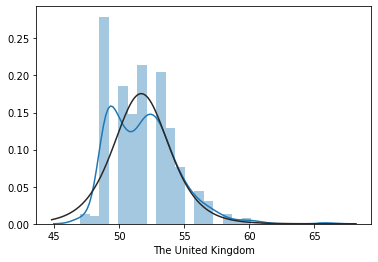

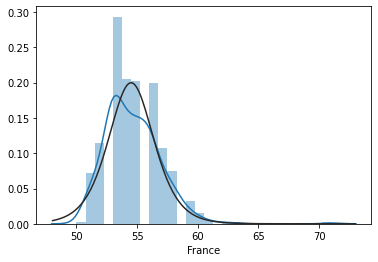

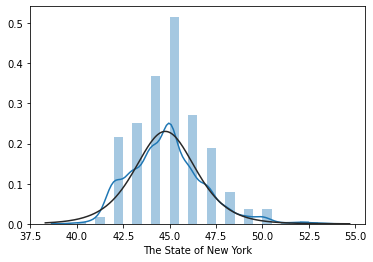

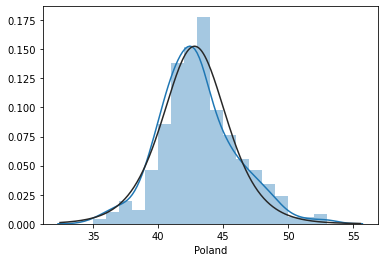

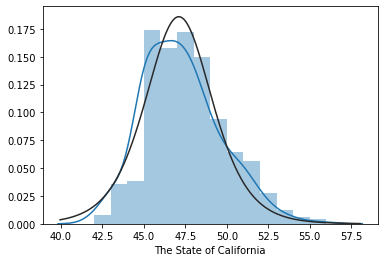

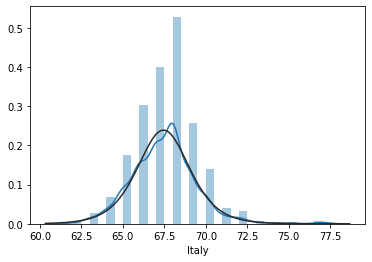

In [0]:
for question in questions:
  plt.figure()
  sns.distplot(samples[question.name], fit = scipy.stats.logistic)

# Submit Predictions

We calculated the model in terms of duration in days. Let's convert that to date format

In [0]:
 for question in questions:
    if question.name in samples:
      start_date = get_assumptions(question)["start"]
      samples[question.name] = samples[question.name].apply(lambda x: start_date + timedelta(days=x))

<class 'pandas.core.series.Series'>


## Submit from sample

In [0]:
def submit_all():
  for question in questions:
    if question.name in samples:
      try:
        params = question.submit_from_samples(samples[question.name])
        print(f"Submitted Logistic{params} for {question.name}")
        print(f"https://pandemic.metaculus.com{question.page_url}")
      except requests.exceptions.HTTPError as e:
        print(f"Couldn't make prediction for {question.name} -- maybe this question is now closed? See error below.")
        print(e)
    else:
      print(f"No predictions for {question.name}")

Submit it!

In [0]:
submit_all()

# Fit Model

Metaculus accepts submissions in terms of a mixture of up to 5 logistic distributions. Take the samples from the generative model and infer the best logistic mixture

In [0]:
def fit_and_plot(samples, num_components):
  learned_mixture_params = logistic.fit_mixture(samples, num_components=num_components)
  def sample_logistic_mixture(mixture_params):
    i = ergo.categorical(torch.Tensor(mixture_params.probs))
    component_params = mixture_params.components[i]
    return np.random.logistic(loc=component_params.loc, scale=component_params.scale)
  learned_samples = np.array([sample_logistic_mixture(learned_mixture_params) for _ in range(5000)])
  ax = sns.distplot(samples, label="Target")
  sns.distplot(learned_samples, label="Fitted")
  plt.legend()
  ax.set(xlabel='Sample value', ylabel='Density')
  return learned_mixture_params

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
100%|██████████| 5000/5000 [00:18<00:00, 273.18it/s]


LogisticMixtureParams(components=[LogisticParams(loc=0.5116737, scale=0.4183891), LogisticParams(loc=0.08080669, scale=0.003948114)], probs=[0.2057126, 0.79428744])

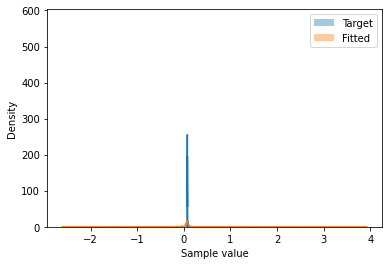

In [0]:
fit_and_plot(samples.iloc[:,0].values, 2)